## Illustration of Ridge Regression

Dans ce notebook, nous nous intéressons à la présence de multicolinéarité dans les données, et à l'impact que cela peut avoir sur un modèle de régression linéaire multiples. 

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Nous allons pour cela, simuler des données en repartant d'hypothèse (variables et bruits gaussiens) que vous avez vu pendant le cours. 

Prenez le temps de comprendre cette fonction et ce qu'elle produit. 

In [2]:
# Définissez ce que cette fonction permet de faire
def make_regression(n_samples, n_uncorrelated, n_correlated, correlation, weights, bias, noise=1, seed=42):

    np.random.seed(seed)

    X_correlated = np.random.multivariate_normal(
        mean=np.zeros(n_correlated),
        cov=correlation * np.ones((n_correlated, n_correlated)) + (1 - correlation) * np.eye(n_correlated),
        size=n_samples
    )

    X_uncorrelated = np.random.multivariate_normal(
        mean=np.zeros(n_uncorrelated),
        cov=np.eye(n_uncorrelated),
        size=n_samples
    )

    X = np.hstack([X_correlated, X_uncorrelated])
    e = np.random.normal(loc=0, scale=noise, size=n_samples)
    y = bias + np.dot(X, weights) + e

    return X, y

In [3]:
# Génération de données
X, y = make_regression(
    n_samples=1000,
    n_uncorrelated=1,
    n_correlated=3,
    correlation=0.999,
    weights=[0.5, 0.5, 0.5, 0.5],
    bias=0,
)

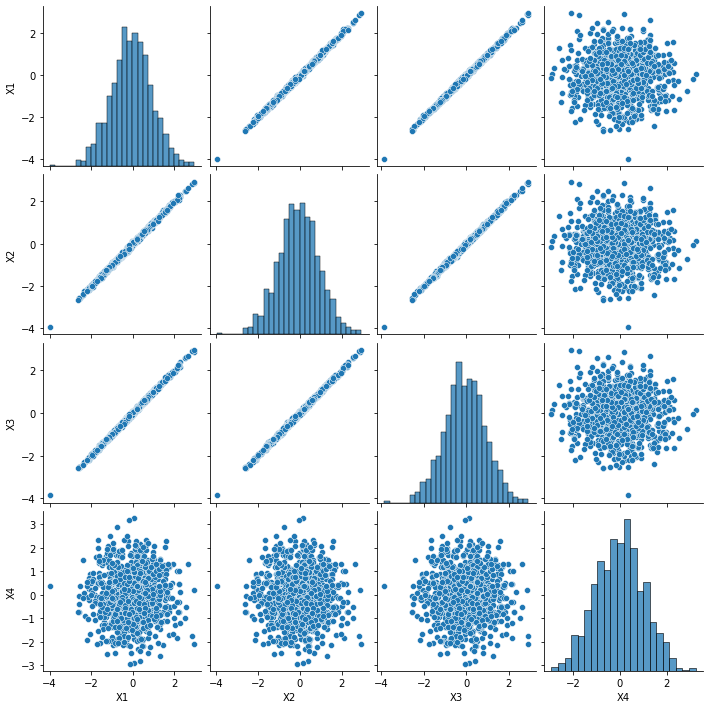

In [4]:
sns.pairplot(pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4']))

In [5]:
print(np.round(np.corrcoef(X, rowvar=False), 1))

[[ 1.  1.  1. -0.]
 [ 1.  1.  1. -0.]
 [ 1.  1.  1. -0.]
 [-0. -0. -0.  1.]]


In [6]:
# On utilise maintenant un modèle de régression linéaire pour apprendre les coefficients de regression
reg = LinearRegression()
reg.fit(X, y)

print(reg.intercept_)
print(reg.coef_)

-0.05034343757101939
[ 0.62245063 -0.43110213  1.31516103  0.52019845]


### Detecting Multicolinearity ? 

Dans l'exemple précédent, nous avons générer des variables colinéaire (corrélé linéairement par paire). 
Que se passe t-il dans le cas ou une variable explicative dépend de plusieurs variables explicatives ? 

In [7]:
X_new = np.array((X[:,0] + X[:,3])/2)
X = np.hstack([X, np.expand_dims(X_new, axis=1)])

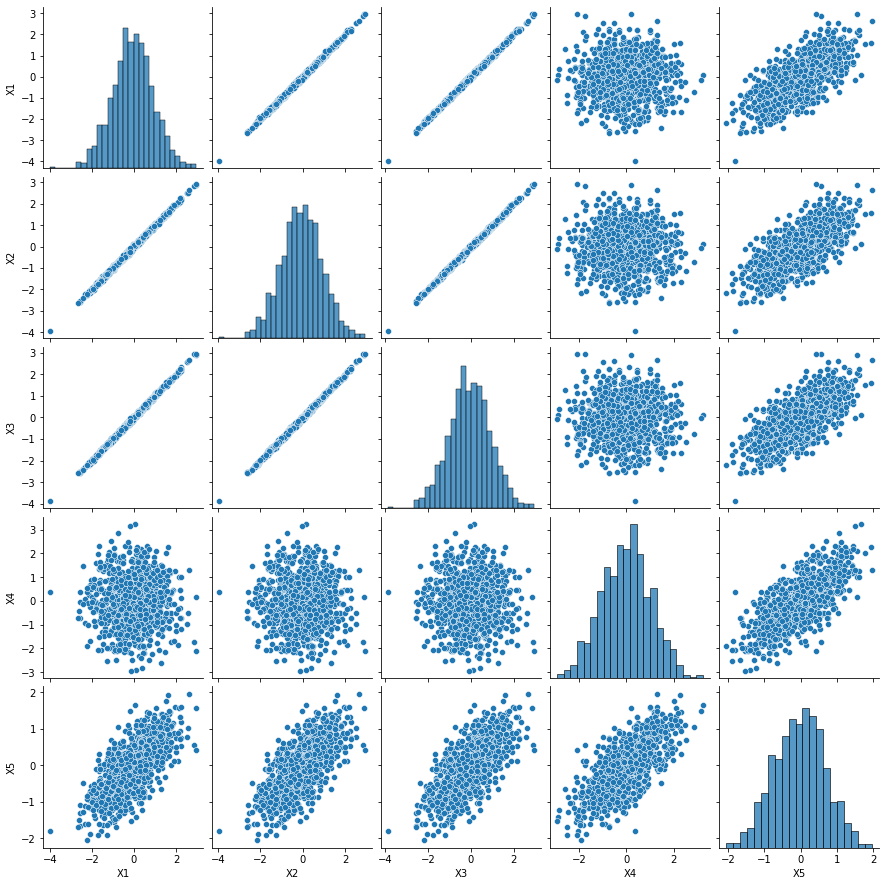

In [8]:
sns.pairplot(pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4', 'X5']))

In [9]:
print(np.round(np.corrcoef(X, rowvar=False), 1))

[[ 1.   1.   1.  -0.   0.7]
 [ 1.   1.   1.  -0.   0.7]
 [ 1.   1.   1.  -0.   0.7]
 [-0.  -0.  -0.   1.   0.7]
 [ 0.7  0.7  0.7  0.7  1. ]]


### Question 1

Supprimer une des trois variables explicatives où coef = 1 et regarder l'impact sur les coefficients

In [10]:
X_trimmed = X[:,[0,2,3,4]]

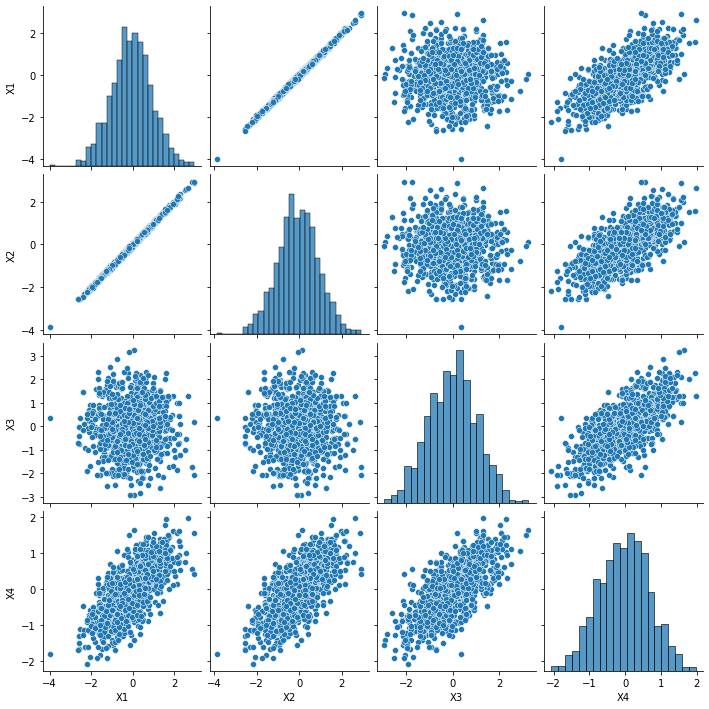

In [11]:
sns.pairplot(pd.DataFrame(X_trimmed, columns=['X1', 'X2', 'X3', 'X4']))

In [12]:
print(np.round(np.corrcoef(X_trimmed, rowvar=False), 1))

[[ 1.   1.  -0.   0.7]
 [ 1.   1.  -0.   0.7]
 [-0.  -0.   1.   0.7]
 [ 0.7  0.7  0.7  1. ]]


In [13]:
# On utilise maintenant un modèle de régression linéaire pour apprendre les coefficients de regression
reg = LinearRegression()
reg.fit(X_trimmed, y)

print(reg.intercept_)
print(reg.coef_)

-0.04965903791821802
[0.26532789 1.08513515 0.36250879 0.31391834]


In [14]:
y_pred = reg.predict(X_trimmed)

rmse = np.sqrt(mean_squared_error(y, y_pred))

print(rmse)

0.9910591935300913


### Question 2

- Utiliser Ridge
- Voir le RMSE

In [15]:
model = Ridge(alpha=10.0).fit(X, y)
print(model.intercept_)
print(model.coef_)

-0.04896994388600469
[0.43950071 0.35958898 0.51237837 0.32472241 0.38211156]


In [16]:
# On utilise maintenant un modèle de régression linéaire pour apprendre les coefficients de regression
reg = LinearRegression()
reg.fit(X, y)

print(reg.intercept_)
print(reg.coef_)

-0.050343437571019445
[ 0.43200911 -0.43110213  1.31516103  0.32975693  0.38088302]


In [17]:
y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))

print(rmse)

0.9915486697259082


In [18]:
n_alphas = 200
alphas = np.logspace(0.1, 10, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

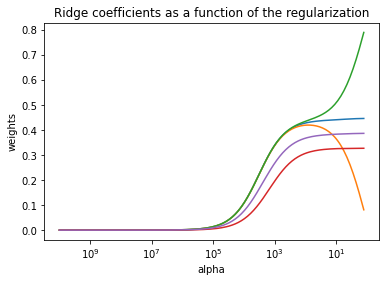

In [19]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

### Question 3

Ridge CV

In [20]:
model = RidgeCV(alphas=(0.1, 1.0, 10.0)).fit(X, y)
print(model.intercept_)
print(model.coef_)

-0.048969943886014444
[0.43950071 0.35958898 0.51237837 0.32472241 0.38211156]


In [21]:
y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))

print(rmse)

0.991548669725909


In [22]:
model.get_params()

{'alpha_per_target': False,
 'alphas': array([ 0.1,  1. , 10. ]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': False,
 'scoring': None,
 'store_cv_values': False}

### Lasso

In [23]:
from sklearn import linear_model

clf = linear_model.Lasso()
clf.fit(X,y)
#Lasso() 
print(clf.coef_)

print(clf.intercept_)

[0.4337405 0.        0.        0.        0.       ]
-0.11720288200364924


In [25]:
y_pred = clf.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))

print(" Erreur quadratique moyenne pour le Lasso :",rmse)

 Erreur quadratique moyenne pour le Lasso : 1.0013669052136664


In [45]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=0.1)
clf.fit(X,y)
#Lasso() 
print(clf.coef_)

print(clf.intercept_)

[0.5508786  0.         0.84822008 0.42272256 0.        ]
-0.057140191715860114


In [46]:
y_pred = clf.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))

print(" Erreur quadratique moyenne pour le Lasso :",rmse)

 Erreur quadratique moyenne pour le Lasso : 1.0013669052136664


In [66]:
#n_alphas = 200
alphas = np.linspace(0.01, 500, 100)
alphas=[0.001,0.005,0.01,0.05,0.1,0.25,0.5,0.75,1,2,3,4,5]
coefs = []
for a in alphas:
    clf = linear_model.Lasso(alpha=a)
    clf.fit(X,y)
    coefs.append(clf.coef_)

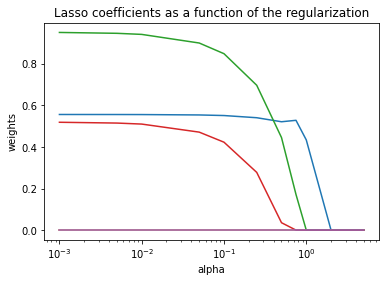

In [65]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

In [44]:
y_pred = clf.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))

print(" Erreur quadratique moyenne pour le Lasso :",rmse)

 Erreur quadratique moyenne pour le Lasso : 1.8370034796052628


In [61]:
#alphas = np.linspace(0.01, 500, 100)
alphas=[0.001,0.005,0.01,0.05,0.1,0.25,0.5,0.75,1,2,3,4,5]

coefs = []
for a in alphas:
    clf = linear_model.Lasso(alpha=[a])
    clf.fit(X,y)
    coefs.append(clf.coef_)
    


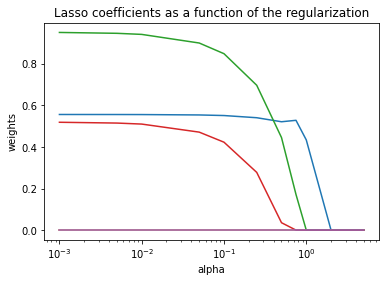

In [59]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

In [54]:
from sklearn.linear_model import LassoCV

reg = LassoCV(cv=10,alphas=[0.001,0.005,0.01,0.05,0.1,0.25,0.5,0.75,1], random_state=0).fit(X, y)
print(reg.coef_)
print(reg.alpha_)


[0.55592258 0.         0.95036456 0.51853478 0.        ]
0.001


In [62]:
alphas=[0.001,0.005,0.01,0.05,0.1,0.25,0.5,0.75,1,2,3,4,5]

coefs = []
for a in alphas:
    reg = LassoCV(cv=10,alphas=[a], random_state=0).fit(X, y)
    coefs.append(reg.coef_)
    

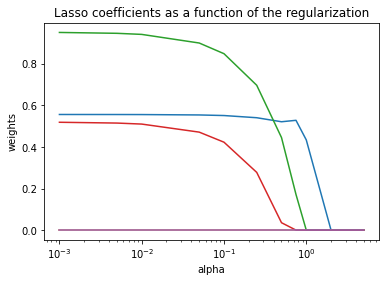

In [63]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

In [68]:
clf = linear_model.Lasso(alpha=0.001)
clf.fit(X,y)

print(clf.coef_)

[0.55592258 0.         0.95036456 0.51853478 0.        ]


[0.44967591 0.02982816 0.91629752 0.40829113 0.2216105 ]
[0.49343415 0.         0.95220027 0.45810481 0.1217052 ]
[0.54560058 0.         0.95362734 0.5115739  0.0142592 ]
[0.55592258 0.         0.95036456 0.51853478 0.        ]


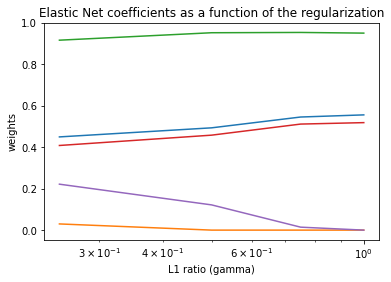

[0.4375589  0.33433213 0.53717132 0.32231951 0.3837594 ]
[0.43627749 0.29185829 0.57918237 0.32058445 0.38412064]
[0.42850471 0.19269273 0.6852989  0.31990291 0.38257073]
[0.55555415 0.         0.94098856 0.5098246  0.        ]


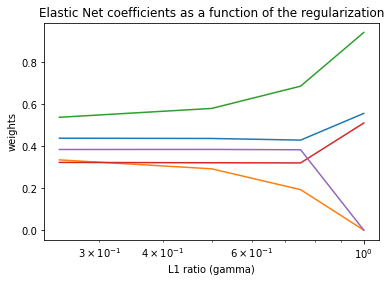

[0.42345299 0.41067168 0.43267277 0.29381382 0.35865492]
[0.4202346  0.40102195 0.43388207 0.28123297 0.35098524]
[0.4178645  0.38049788 0.4447016  0.26789527 0.34371019]
[0.5508786  0.         0.84822008 0.42272256 0.        ]


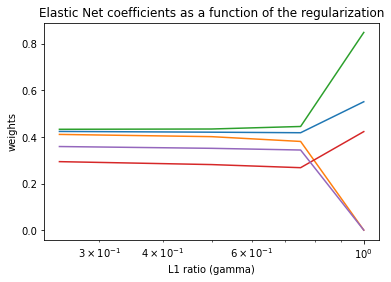

In [71]:
from sklearn.linear_model import ElasticNet


alphas=0.01#[0.001,0.01,0.1]
l1_ratios=[0.25,0.5,0.75,1]

for a in alphas:
    coefs = []

    for l in l1_ratios:
        regr = ElasticNet(alpha=a, l1_ratio=l, random_state=0)
        regr.fit(X, y)
        print(regr.coef_)
        coefs.append(regr.coef_)
        
    ax = plt.gca()

    ax.plot(l1_ratios, coefs)
    ax.set_xscale("log")
    #ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("L1 ratio (gamma)")
    plt.ylabel("weights")
    plt.title("Elastic Net coefficients as a function of the regularization")
    plt.axis("tight")
    plt.show()

        
    

[0.44253405 0.00821347 0.86337523 0.32687592 0.38461426]
[0.42295199 0.         0.91107861 0.34668916 0.3447352 ]
[0.40586867 0.         0.94921105 0.36759489 0.30257642]
[0.39511266 0.         1.00642761 0.4138885  0.20964226]
[0.47232513 0.         1.03399475 0.51851313 0.        ]


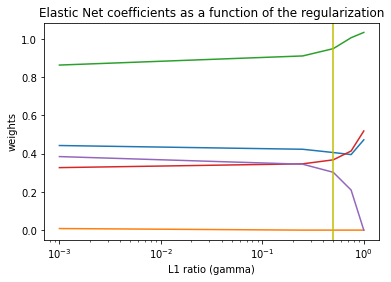

In [102]:
from sklearn.linear_model import ElasticNetCV

alphas=[0.001]#[0.001,0.01,0.1]
l1_ratios=[0.001,0.25,0.5,0.75,1]

for a in alphas:
    coefs = []

    for l in l1_ratios:
        regr = ElasticNetCV(cv=5,l1_ratio=[l],alphas=[a],random_state=0, max_iter=30000)
        regr.fit(X, y)
        print(regr.coef_)
        coefs.append(regr.coef_)
        
    ax = plt.gca()

    ax.plot(l1_ratios, coefs)
    plt.axvline(x=0.5, color="y")
    ax.set_xscale("log")
    #ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("L1 ratio (gamma)")
    plt.ylabel("weights")
    plt.title("Elastic Net coefficients as a function of the regularization")
    plt.axis("tight")
    plt.show()
    


In [98]:
regr = ElasticNetCV(cv=5,l1_ratio=l1_ratios,alphas=alphas,random_state=0, max_iter=30000)
regr.fit(X, y)
print("Le meilleur alpha au sens de Elastic Net est :",regr.alpha_,"\n")
print("Le meilleur gamma au sens de Elastic Net est :",regr.l1_ratio_,"\n")
print("Les coefficients correspondant aux meilleures valeurs de alpha (",regr.alpha_ ," ) et gamma ( ",regr.alpha_ ," ) au sens de Elastic Net est : ",regr.coef_,"\n")

Le meilleur alpha au sens de Elastic Net est : 0.001 

Le meilleur gamma au sens de Elastic Net est : 0.5 

Les coefficients correspondant aux meilleures valeurs de alpha ( 0.001  ) et gamma (  0.001  ) au sens de Elastic Net est :  [0.40586867 0.         0.94921105 0.36759489 0.30257642] 



In [97]:


regr = ElasticNet(alpha=0.01, l1_ratio=0.2, random_state=0, max_iter=5000)
regr.fit(X, y)
print(regr.coef_)
coefs.append(regr.coef_)

[0.43789262 0.34004693 0.53146685 0.32266679 0.38369367]
